# Project Proposal

Group Number: 4

Group Members:Kaiji Lo, Hao Jiang, Jezarah Ebel, Yoson Hsu, Amar Gill

Data Set: Data Science Jobs Salaries

In [1]:
library(cowplot)
library(dplyr)
library(gridExtra)
library(tidyverse)
library(repr)
library(infer)
library(broom)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()



## Introduction

During COVID-19 the work from home (WFH) model was adopted by many companies to keep employees safe from the virus; 32% of Canadian employees in 2021 worked from home compared to 4% in 2016 (Mehdi). In general, it has been proven that employee’s productivity is not affected if their personal work environment at home provides good privacy, noise, and allows developers to work with less fragmentation or interruptions (Bao). 

Should an employee expect their salary to change based on where they work (from home or at the office)?

To explore this question, the dataset that we will be using, Data Science Jobs Salaries Dataset, includes salary data for employees in the data science industry such as the work year, experience level, employment type, the job title, salary, employee residence, the ratio of remote work, location of company, and size of company. To answer our questions, we will be looking at the salary in USD and the ratio of remote work (0% remote vs. 100% remote). 


# Preliminary Results

## Cleaning and Wrangling of Data

In [2]:
download.file("https://raw.githubusercontent.com/Wills-Hao/201-Project/main/Data_Science_Jobs_Salaries.csv", destfile = "Data_Science_Jobs_Salaries.csv")

DsSalary <- read_csv("Data_Science_Jobs_Salaries.csv")
head(DsSalary)

Rows: 245 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (4): work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
2021,EN,FT,Data Science Consultant,54000,EUR,64369,DE,50,DE,L
2020,SE,FT,Data Scientist,60000,EUR,68428,GR,100,US,L
2021,EX,FT,Head of Data Science,85000,USD,85000,RU,0,RU,M
2021,EX,FT,Head of Data,230000,USD,230000,RU,50,RU,L
2021,EN,FT,Machine Learning Engineer,125000,USD,125000,US,100,US,S
2021,SE,FT,Data Analytics Manager,120000,USD,120000,US,100,US,M


As the introduction mentioned, we are interested in the data-related workers working remotely or not (the remote ratio of 0 and 100). Since the remote ratio and the salary(USD) are the only columns we are interested in, we just select them for the cleaned data frame.

In [3]:
clean_DsSalary <- DsSalary %>%
                  filter(!is.na(salary_in_usd&remote_ratio),
                         remote_ratio %in% c(0, 100)) %>%
                  mutate(remote_ratio = as_factor(remote_ratio)) %>%
                  select(remote_ratio, salary_in_usd)
head(clean_DsSalary)

remote_ratio,salary_in_usd
<fct>,<dbl>
100,68428
0,85000
100,125000
100,120000
0,450000
100,144000


## Estimation of the Parameter

At first, we separately calculated the mean salaries of data-related workers who worked remotely (remote ratio > 80%) and the mean salaries of data-related workers who didn't work remotely (remote ratio < 20%). From the result below, we can see that the mean salary of remote workers has higher salaries. Then we find the difference between the two means is around 30145.229 USD, which can be seen as an estimation of the parameter.

In [4]:
remote_df <- clean_DsSalary %>%
                  filter(remote_ratio == 100) %>%
                  select(salary_in_usd)
 
remote_mean <- remote_df %>%
                summarise(mean_remote = mean(salary_in_usd))
remote_mean

no_remote_df <- clean_DsSalary %>%
                filter(remote_ratio == 0) %>%
                select(salary_in_usd)

no_remote_mean <- no_remote_df %>%
                 summarise(mean_office = mean(salary_in_usd))
no_remote_mean

mean_remote
<dbl>
115107.7


mean_office
<dbl>
84962.45


In [16]:
estimation_diff_mean <- pull(remote_mean) - pull(no_remote_mean)
estimation_diff_mean
options(scipen = 100)

[1] 30145.23

In [36]:
?options

options {base},R Documentation
...,"any options can be defined, using name = value. However, only the ones below are used in base R. Options can also be passed by giving a single unnamed argument which is a named list."
x,a character string holding an option name.
default,"if the specified option is not set in the options list, this value is returned. This facilitates retrieving an option and checking whether it is set and setting it separately if not."
add.smooth,TRUE
check.bounds,FALSE
continue,"""+ """
digits,7
echo,TRUE
encoding,"""native.enc"""
error,NULL


## Visualizing the Data

Firstly, we will plot the raw data distribution of two data frames(the remote working one and the no remote working one) with the vertical lines of their mean value. By comparing them, we can see that the mean salary of remote workers has a higher value of salary.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


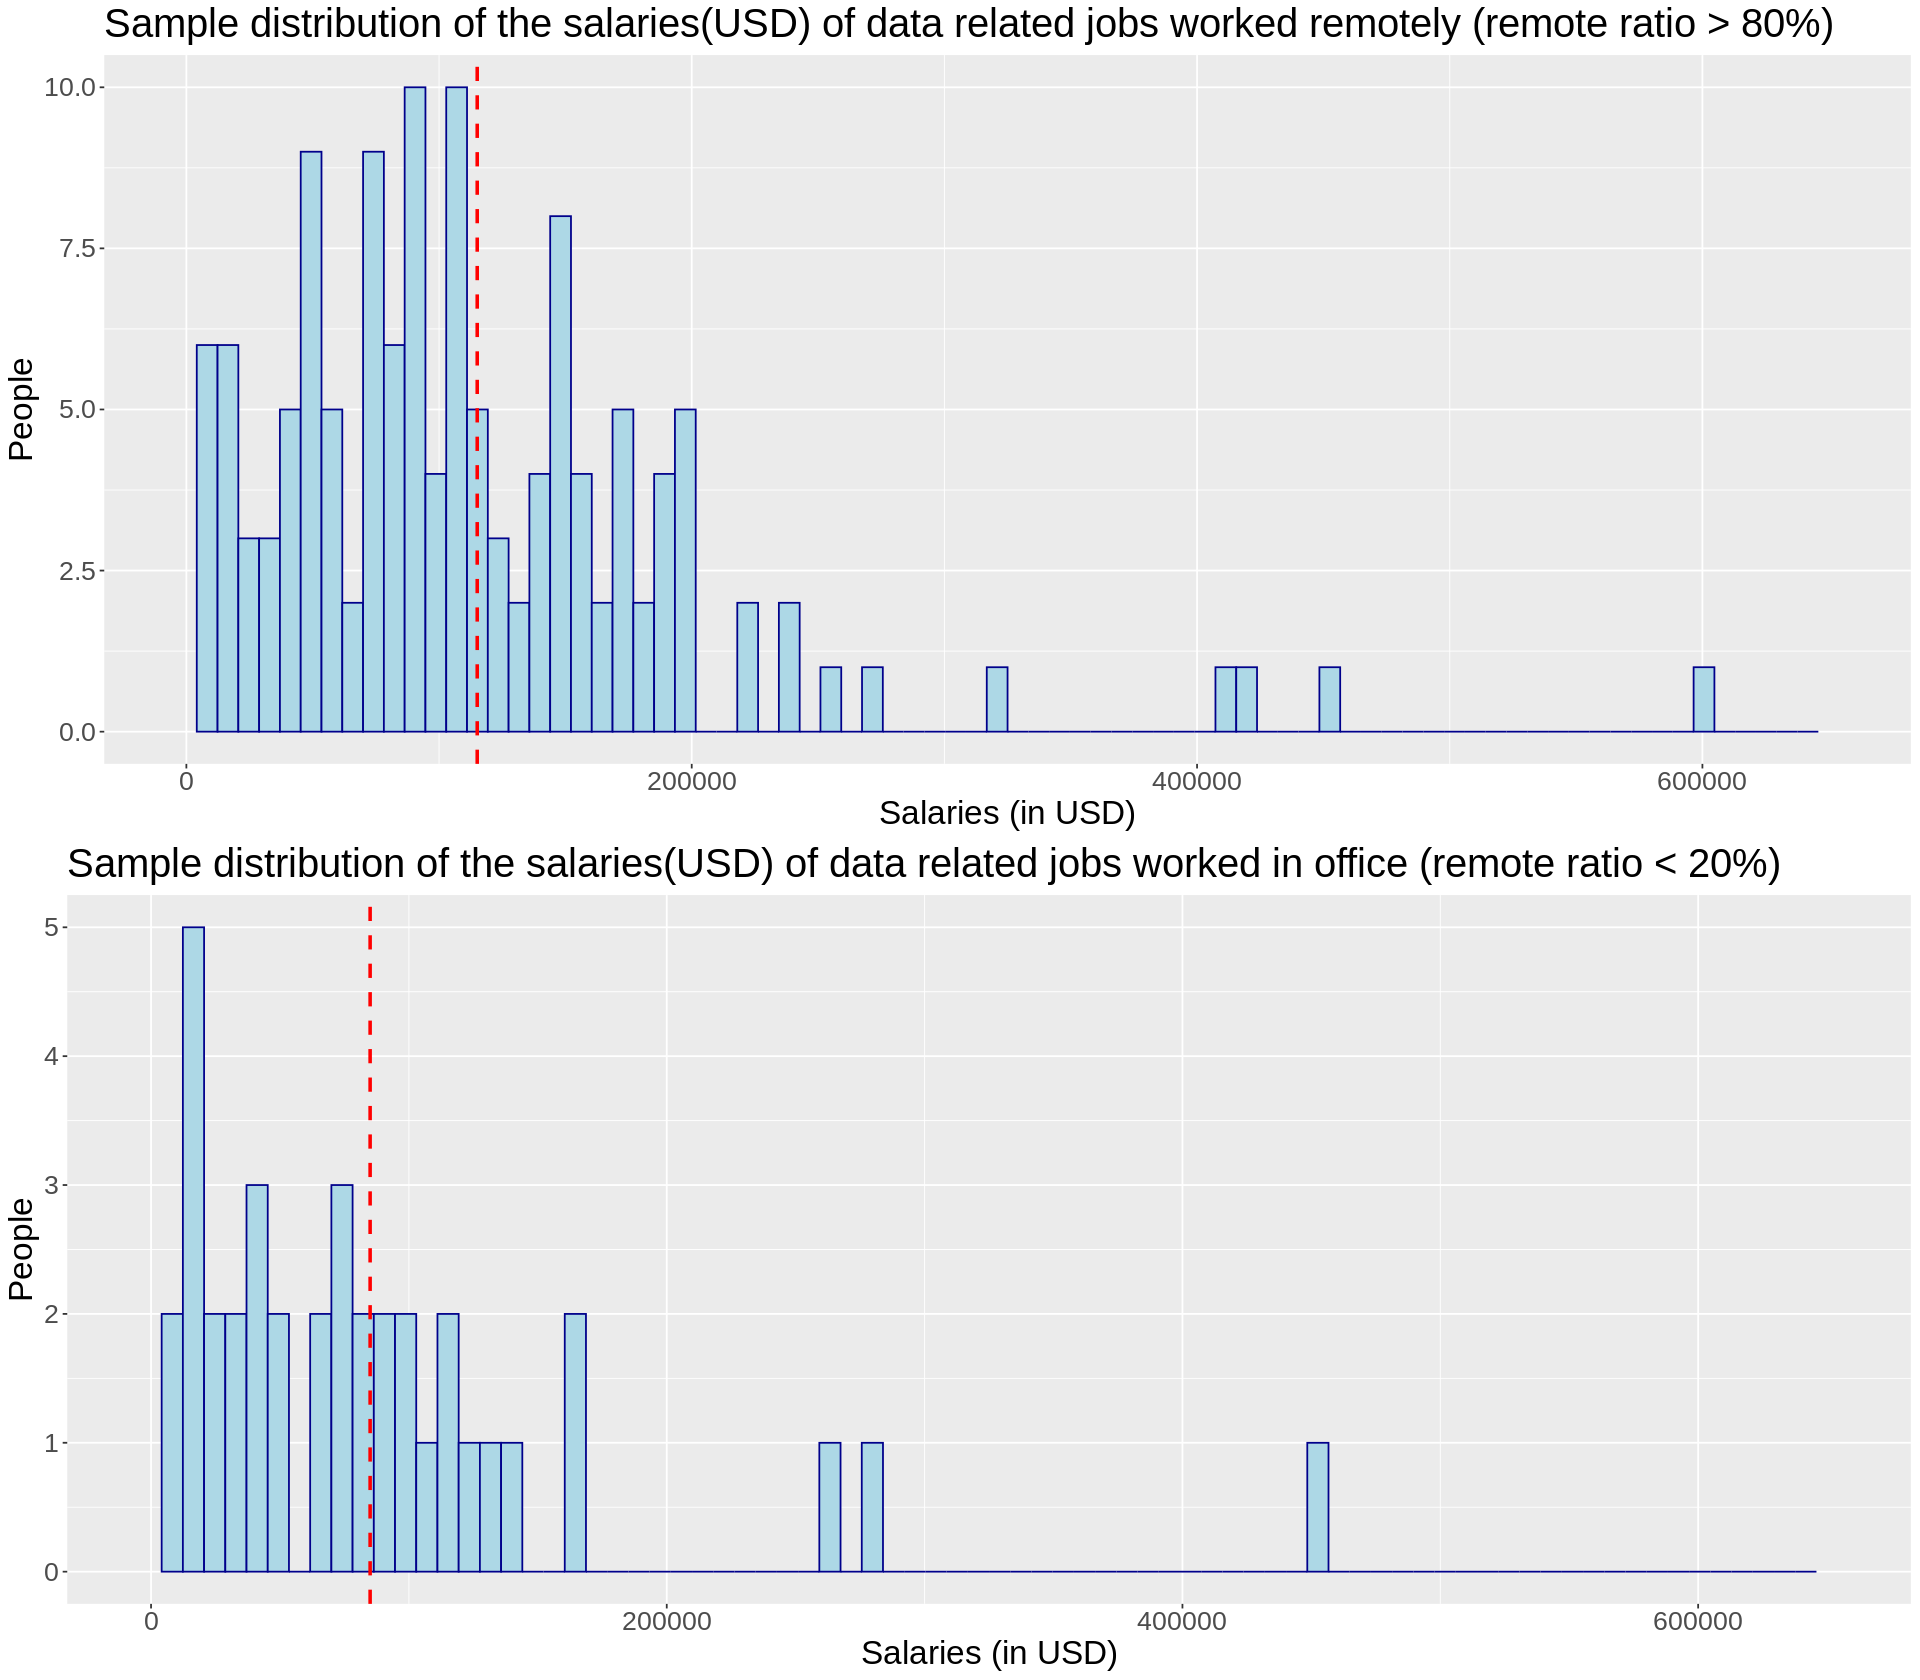

In [17]:
remote_distribution <- remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(bins=80, color="darkblue", fill="lightblue") +
                          geom_vline(aes(xintercept = pull(remote_mean)), color="red", linetype="dashed", size = 1)+
                          ggtitle("Sample distribution of the salaries(USD) of data related jobs worked remotely (remote ratio > 80%)")+
                          labs(x="Salaries (in USD)",
                               y="People")+
                          theme(text = element_text(size=20)) 

no_remote_distribution <- no_remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(bins=80, color="darkblue", fill="lightblue") +
                          geom_vline(aes(xintercept = pull(no_remote_mean)), color="red", linetype="dashed", size = 1)+
                          ggtitle("Sample distribution of the salaries(USD) of data related jobs worked in office (remote ratio < 20%)")+
                          labs(x="Salaries (in USD)",
                               y="People")+
                          theme(text = element_text(size=20))

options(repr.plot.width = 16, repr.plot.height = 14)

mean_plot_row <- plot_grid(remote_distribution+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           no_remote_distribution+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           nrow = 2)
mean_plot_row

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


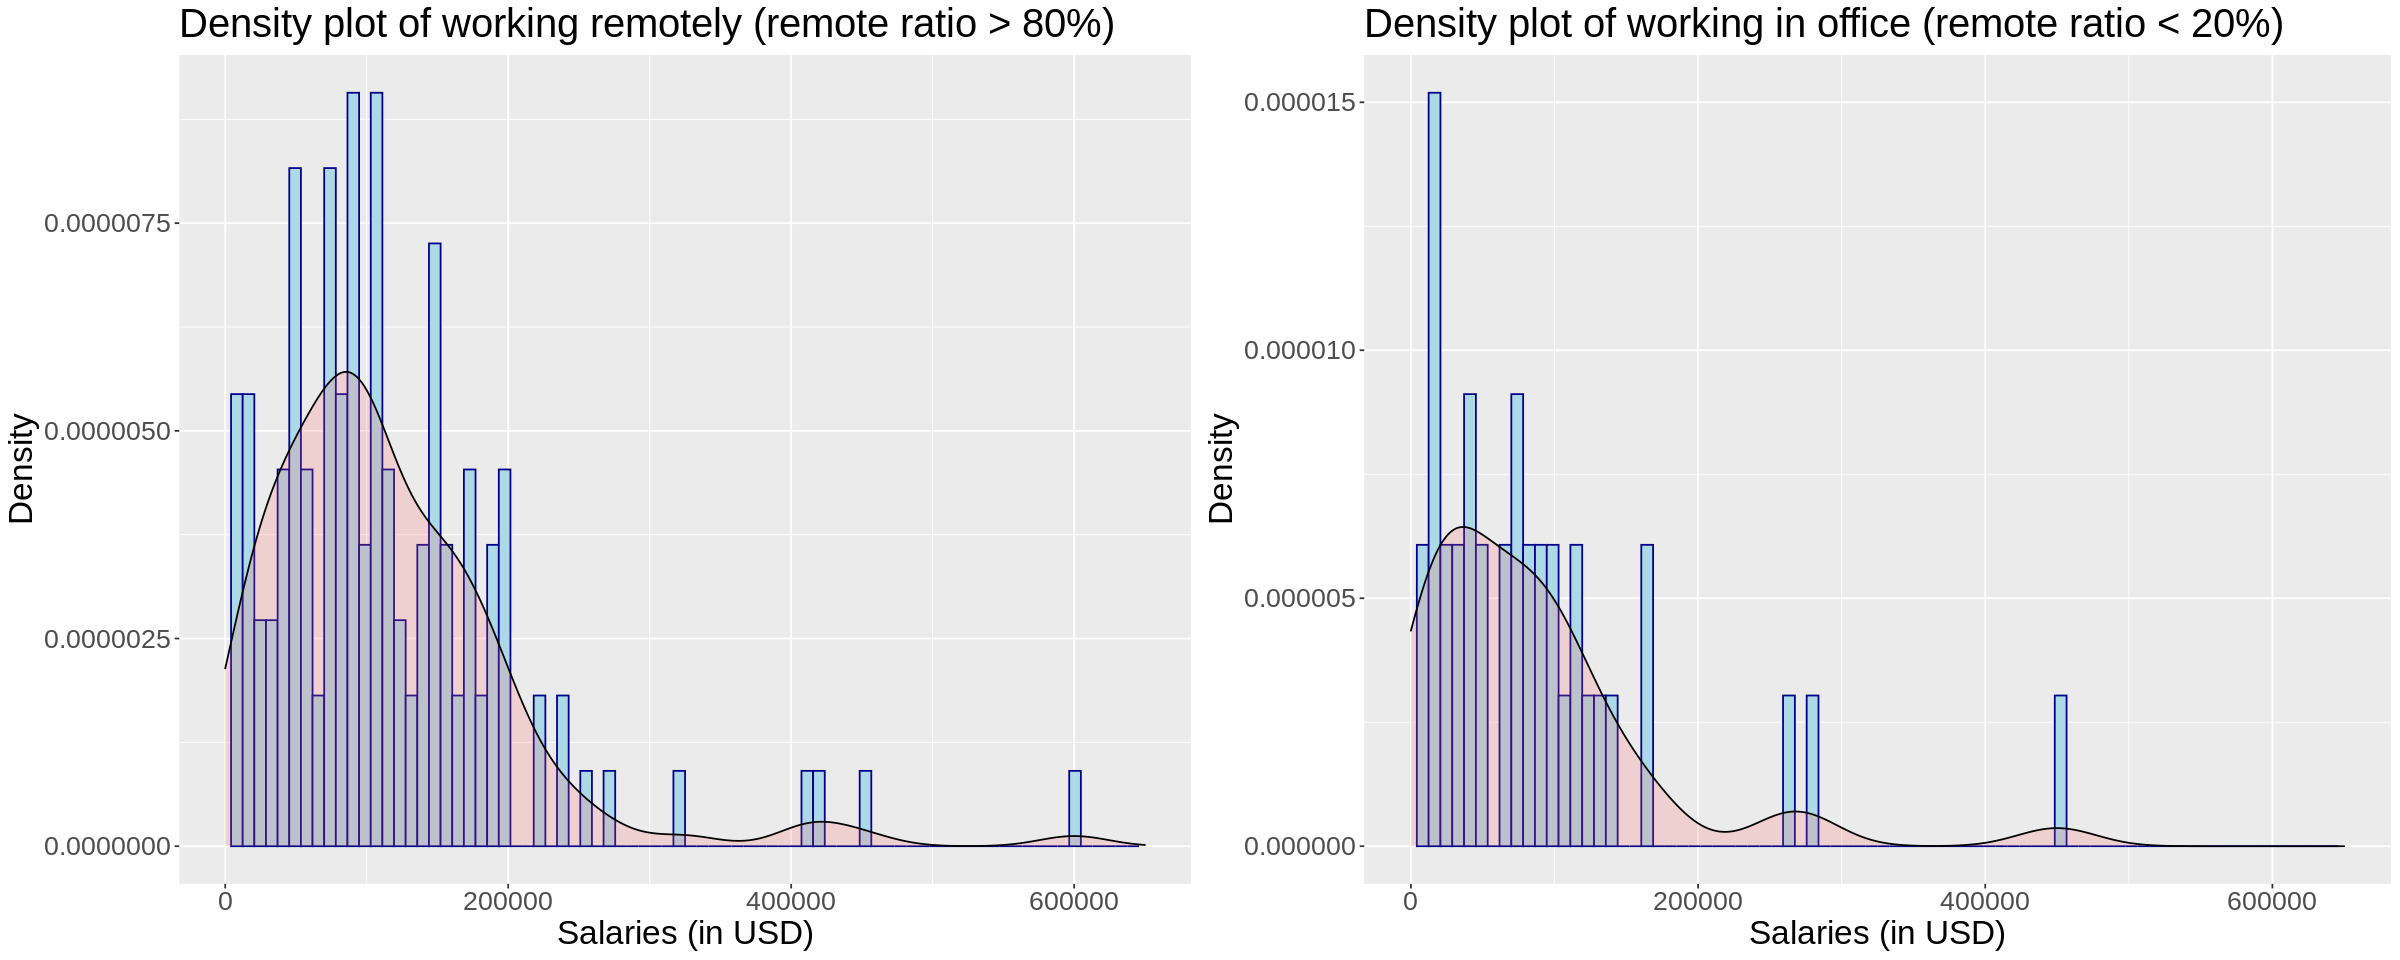

In [18]:

remote_density <- remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(aes(y=..density..), bins=80, color="darkblue", fill="lightblue") +
                          geom_density(alpha=.2, fill="#FF6666")+
                          labs(x = "Salaries (in USD)",
                               y = "Density")+
                          ggtitle("Density plot of working remotely (remote ratio > 80%)")+
                          theme(text = element_text(size=20))
no_remote_density <- no_remote_df %>%
                          ggplot(aes(x=salary_in_usd)) +
                          geom_histogram(aes(y=..density..), bins=80, color="darkblue", fill="lightblue") +
                          geom_density(alpha=.2, fill="#FF6666")+
                          labs(x = "Salaries (in USD)",
                               y = "Density")+
                          ggtitle("Density plot of working in office (remote ratio < 20%)")+
                          theme(text = element_text(size=20))

options(repr.plot.width = 20, repr.plot.height = 8)

density_plot <- plot_grid(remote_density+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           no_remote_density+
                           scale_x_continuous(limits = c(0, 6.5e+05)),
                           ncol = 2)
density_plot

From the density plots, we can see both of them are skewed to the right.

# Hypothesis Testing

For this section, we will use hypothesis testing to determine whether there is enough statistical evidence in favor of the statement that the mean salary for data scientists who work remotely is different from the mean salary for data scientists who does not work remotely. For this project, we set the 0.95 `confidence level`, which means a 0.05 significance level.

The null hypothesis ($H_0$): There is `no difference` between the mean salary for data scientists who work remotely and the mean salary for data scientists who does not work remotely.

The alternative hypothesis ($H_A$): There is `a difference` between the mean salary for data scientists who work remotely and the mean salary for data scientists who does not work remotely.


$\mu_1$: The population mean of salary for data scientists who `work remotely`

$\mu_2$: The population mean of salary for data scientists who does not `work remotely`

$H_0: \mu_1 - \mu_2 = 0$

$H_A: \mu_1 - \mu_2 \neq 0$

### Bootstrapping method

First, we will review the `observed test statistic` (the difference between the mean salary for data scientists who work remotely and the mean salary for data scientists who does not work remotely from the dataset) calculated in the preliminary results section. Then, we will use the `infer` package to obtain the bootstrapped sampling distribution to estimate the sampling distribution, so that we can use it to find out the `p-value` (the probability of getting a value more "extreme" than the observed test statistic). Also, we will construct a `confidence interval` based of the confidence level on the bootstrap distribution. Based on the p-value and the confidence interval, we can reject or not reject the null hypothesis $H_0$. 

In [19]:
# Review of the obeserved test statistic
cat("The value of the observed test statistic is", estimation_diff_mean)

The value of the observed test statistic is 30145.23

#### Find the null distribution and the p-value 

In [20]:
# Using the infer package, to obtain the bootstrapped sampling distribution of test statistic 
# by 1000 replications
set.seed(111)

sampling_dist_mean_salary <-  
   clean_DsSalary %>%
   specify(formula = salary_in_usd ~ remote_ratio) %>% 
   hypothesize(null = "independence") %>% 
   generate(reps = 1000, type = "permute") %>% 
   calculate(stat="diff in means", order = c(100, 0))

head(sampling_dist_mean_salary)

replicate,stat
<int>,<dbl>
1,3536.019
2,-19729.241
3,18289.759
4,-26341.826
5,-2065.482
6,-15321.588


Since the alternative hypothesis is $\mu_1 - \mu_2 \neq 0$, we will find the p-value by the two sided direction (region shaded in red below). 

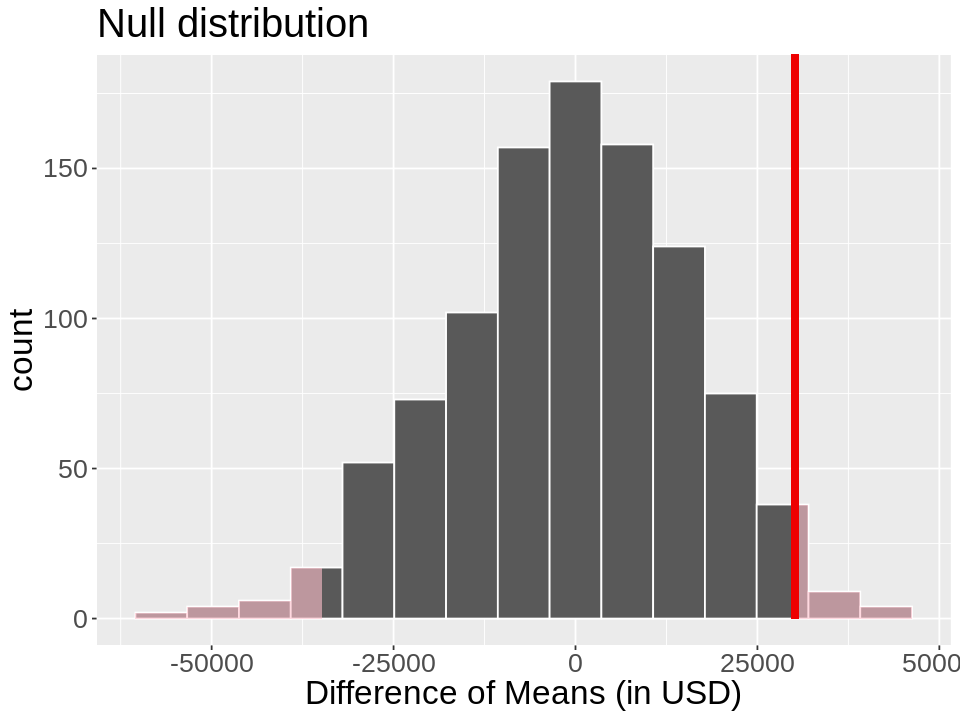

In [21]:
# Plot the result of the hypothesis test with the vertical line of the test statistic's position

options(repr.plot.width = 8, repr.plot.height = 6)
result_plot_students <- 
   sampling_dist_mean_salary %>%
   visualize() + 
   shade_p_value(obs_stat = estimation_diff_mean, direction = "two-sided") +
   ggtitle("Null distribution")+
   labs(x = "Difference of Means (in USD)")+
   theme(text = element_text(size = 20))

result_plot_students

In [22]:
# Obtaining the p-value

p_value_mean_salary <- 
    sampling_dist_mean_salary %>% 
    get_p_value(obs_stat = estimation_diff_mean, direction = "two-sided") %>%
    pull()

cat("The P-value is", p_value_mean_salary)

The P-value is 0.04

#### Find the bootstrap distribution and the 95% confidence interval

In [23]:
# Using the infer package, to obtain the bootstrap distribution of test statistic by 1000 replications
set.seed(222)

bootstrap_dist_diff_in_mean <-  
   clean_DsSalary %>%
   specify(formula = salary_in_usd ~ remote_ratio) %>% 
   generate(reps = 1000, type = "bootstrap") %>% 
   calculate(stat="diff in means", order = c(100, 0))

# Obtain the 95% confidence interval
diff_in_means_ci <- bootstrap_dist_diff_in_mean %>%
                    get_confidence_interval(level = 0.95, type = "percentile") 

diff_in_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
515.3215,57918.65


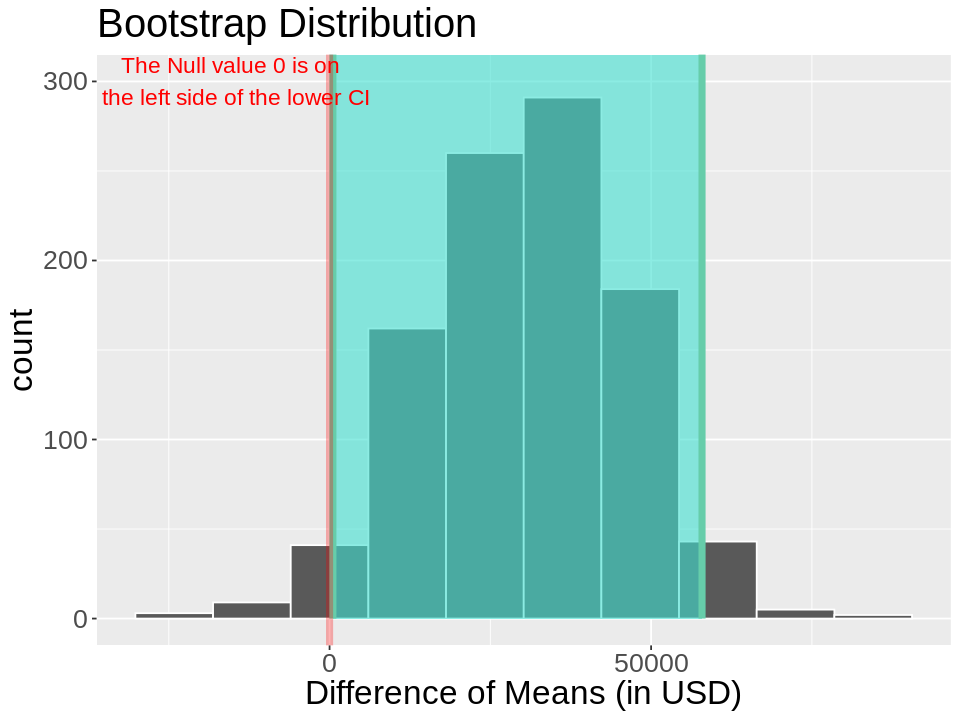

In [24]:
# The Plot of the confidence interval in bootstrap distribution with a vertical line 
# of the value of H_0 (null value)

options(repr.plot.width = 8, repr.plot.height = 6)
diff_in_means_ci_plot <- bootstrap_dist_diff_in_mean %>%
                        visualize(bins = 10) +
                        shade_confidence_interval(endpoints = diff_in_means_ci) +
                        xlab("Difference of Means (in USD)")+
                        ggtitle("Bootstrap Distribution") +
                    geom_vline(xintercept = 0, color = "red", alpha=.3, lwd=2)+
                    annotate("text", x = -15000, 
                             y =300, label = "The Null value 0 is on \n the left side of the lower CI", 
                             color="red", size=4.8)+
                    theme(text = element_text(size = 20))
    
diff_in_means_ci_plot

#### Result of the bootstrap method:

Two methods are used to determine whether reject the null hypothesis (no difference), one is by comparing the p-value and the significance level, and another is by determining whether the confidence interval embraced the value of the null hypothesis which is 0 (null value). 

First of all, the `p-value` of 0.04 which is smaller than the `significant level` of 0.05 is statistically significant. It shows strong evidence against the null hypothesis because the probability of the null hypothesis being correct is less than 5%. Therefore, we reject the null hypothesis and accept the alternative hypothesis.

Secondly, the `null value` of the difference between two groups' mean salary is 0, which is not contained in the `confidence interval` (515.3215, 57918.65). It indicates that the null value 0 is not a reasonable value for the true difference in mean salaries between the two groups. Thus, we reject the null hypothesis and accept the alternative hypothesis.

In summary, there is a difference between the mean of salary for data scientists who work remotely and the mean of salary for data scientists who does not work remotely. Our findings suggest that remote work pays more, employees can work from anywhere around the world.

### Central Limit Theorem 

There are alternatives to bootstrapping when it comes to studying sampling distributions, specifically methods that rely on mathematical modelling and approximations. One method relies on the `central limit theorem` which tells us that when we increase our sample size and take a sampling distribution that we reduce the variability of sample means. This reduction in variability improves the centre of our sampling distribution and thus the quality of the estimate. 

Central Limit Theorem is also useful in our scenario, as it states if our sample size if large enough our sampling distribution can be approximated with a normal distribution regardless of the population distribution. This is a useful approximation for us because we don't know the distribution of our population and we have no feasible way of gathering that information. By taking the sampling distribution and applying the central limit theorem we can theoretically make a better estimate for our parameter of interest (difference in means). Note we are additionally assuming that our sample is unbiased. 

#### Samples

Since we are interested in the difference between two related populations, our samples will need to be taken from both groups. As shown above we do have a larger number of observations from fully remote workers (134) than from in office workers (40).

In [25]:
remote_ratio_0 <- clean_DsSalary %>%
    mutate(remote_ratio_factor = as.factor(remote_ratio)) %>%
    filter(remote_ratio_factor == "0") %>%
    select(remote_ratio, salary_in_usd)

remote_ratio_100 <- clean_DsSalary %>%
    mutate(remote_ratio_factor = as.factor(remote_ratio)) %>%
    filter(remote_ratio_factor == "100") %>%
    select(remote_ratio, salary_in_usd)

In [30]:
set.seed(2000)

sample_10_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 10, reps = 3000, replace = FALSE)

sample_10_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 10, reps = 3000, replace = FALSE)

sample_10 <- merge(sample_10_0, sample_10_100,
                    all = TRUE)

sample_20_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 20, reps = 3000, replace = FALSE)

sample_20_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 20, reps = 3000, replace = FALSE)

sample_20 <- merge(sample_20_0, sample_20_100,
                    all = TRUE)

sample_30_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 30, reps = 3000, replace = FALSE)

sample_30_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 30, reps = 3000, replace = FALSE)

sample_30 <- merge(sample_30_0, sample_30_100,
                    all = TRUE)

sample_40_0 <- remote_ratio_0 %>%
    rep_sample_n(size = 40, reps = 3000, replace = FALSE)

sample_40_100 <- remote_ratio_100 %>%
    rep_sample_n(size = 40, reps = 3000, replace = FALSE)

sample_40 <- merge(sample_40_0, sample_40_100,
                    all = TRUE)

Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


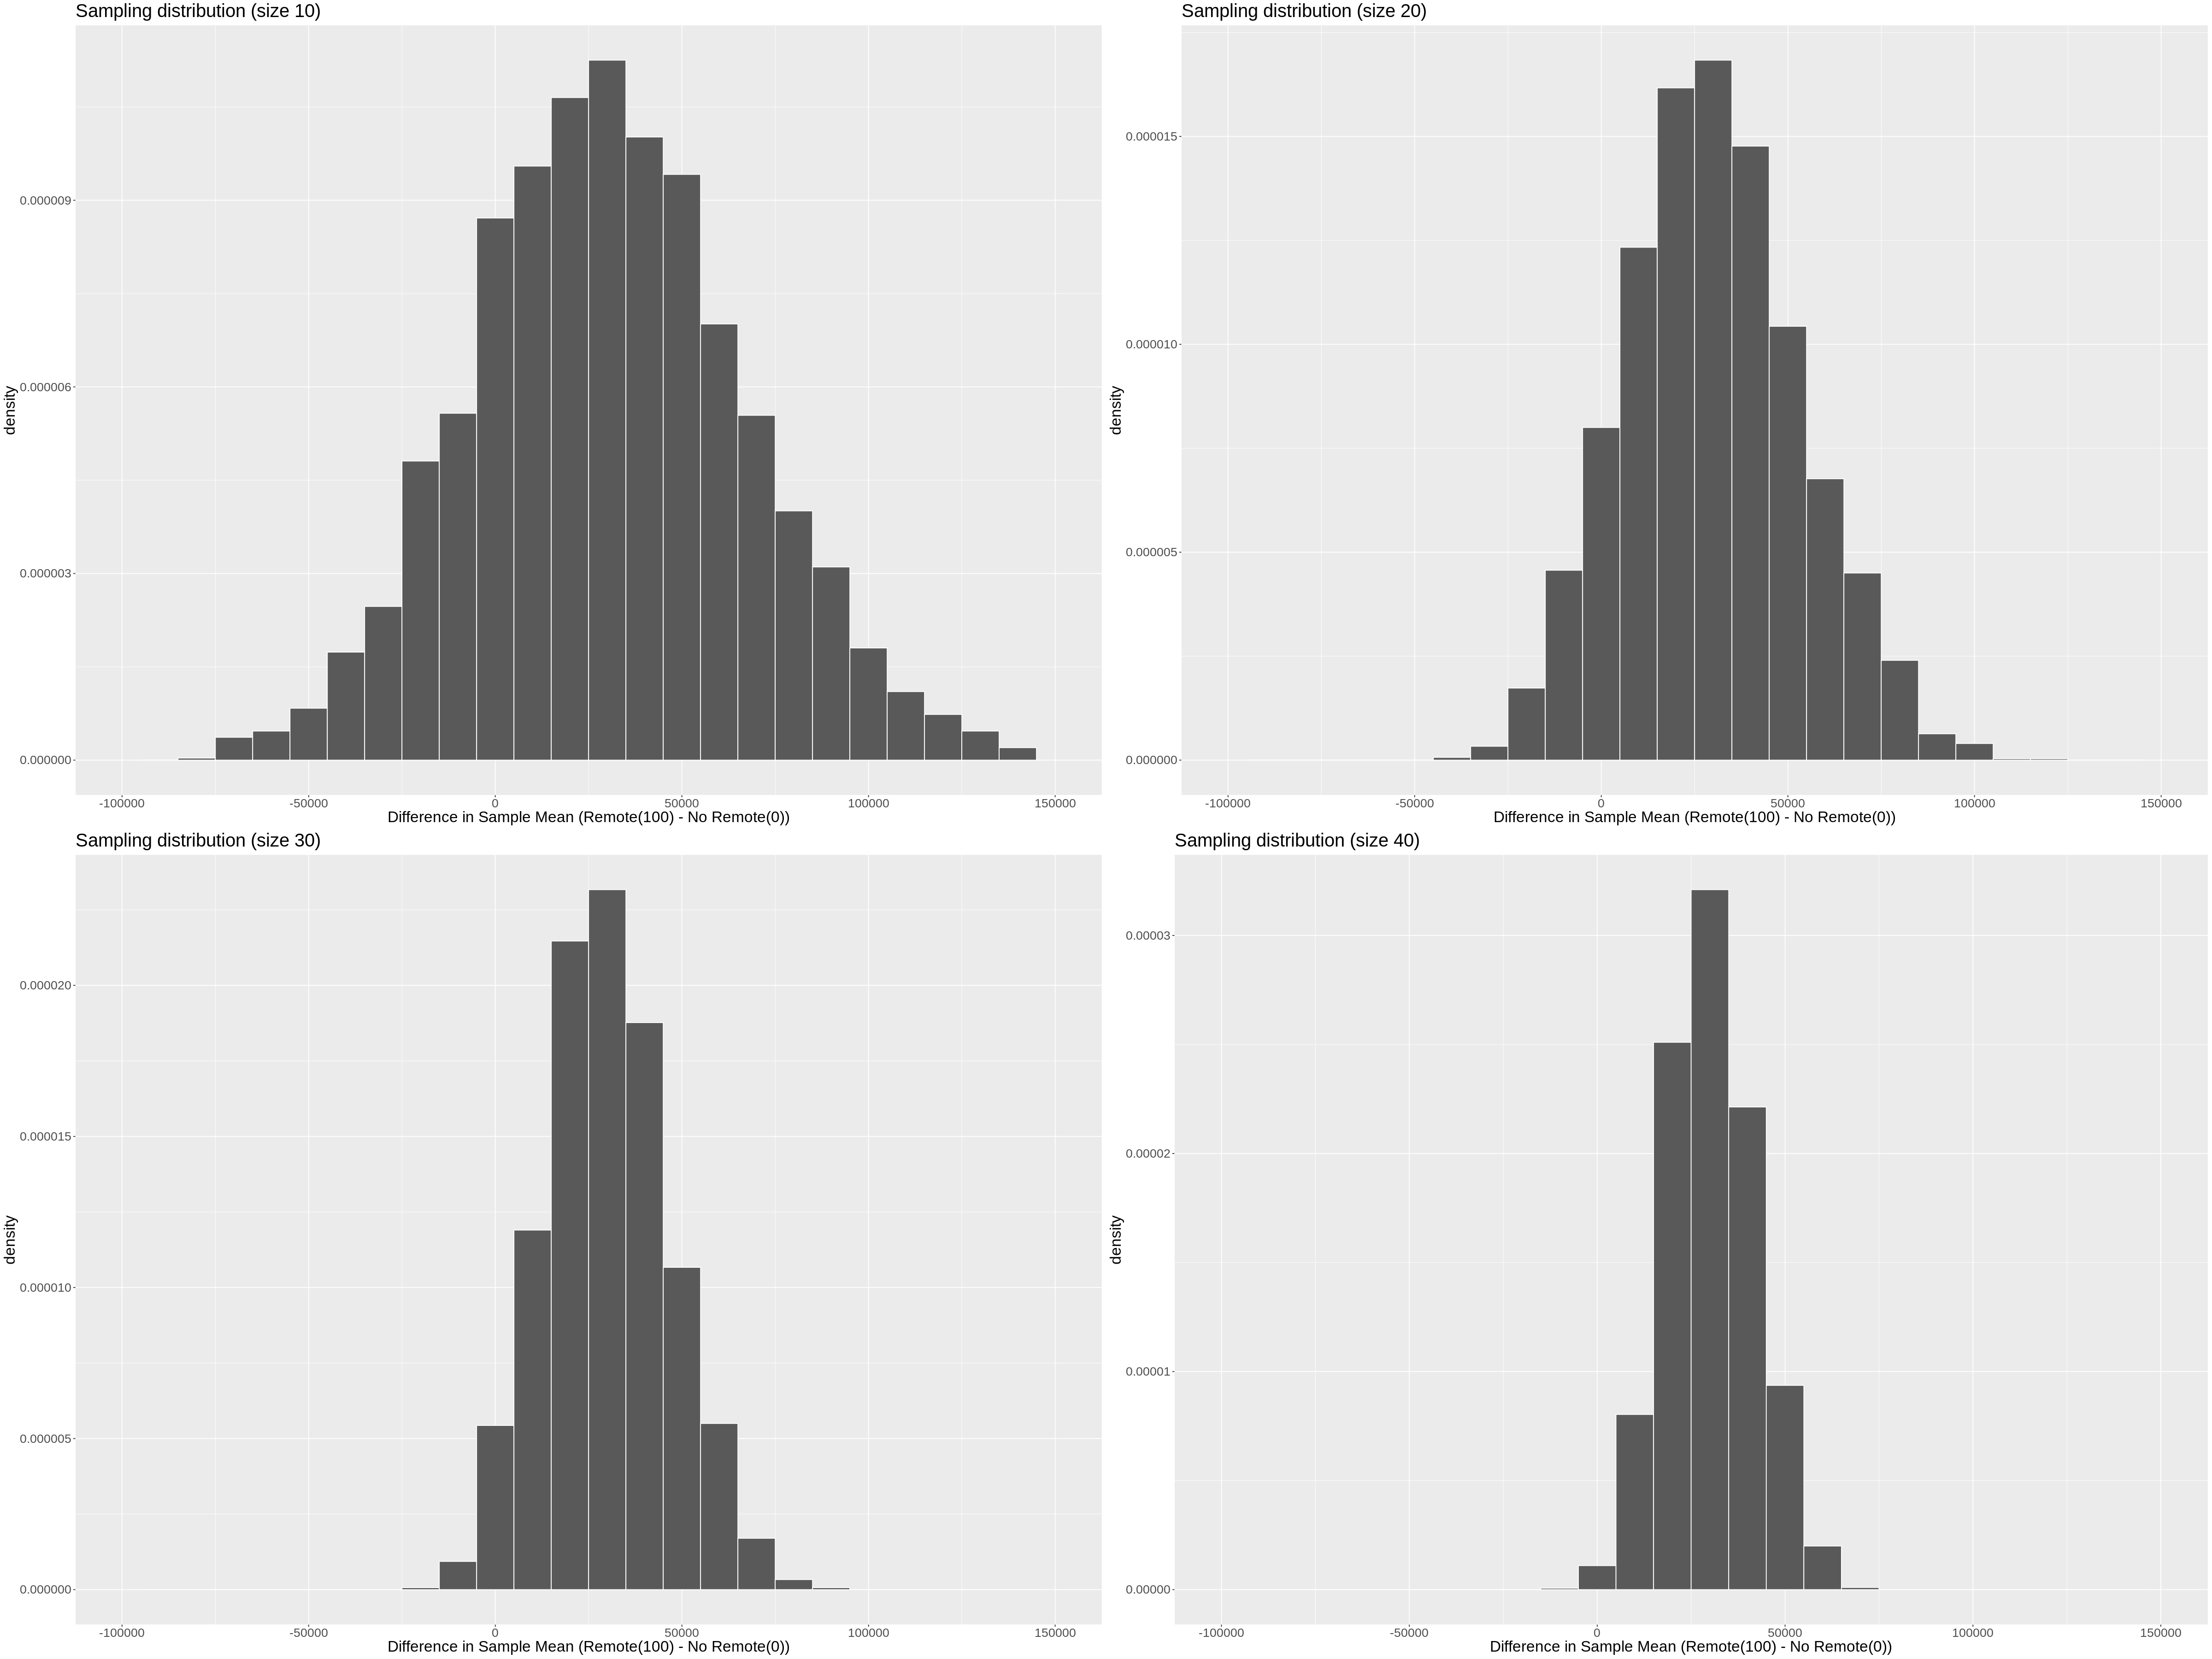

In [35]:
options(repr.plot.width=40, repr.plot.height=30)
sampling_dist_10 <- sample_10 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote(100) - No Remote(0))") +
    ggtitle("Sampling distribution (size 10)")  

sampling_dist_20 <- sample_20 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote(100) - No Remote(0))") +
    ggtitle("Sampling distribution (size 20)")  

sampling_dist_30 <- sample_30 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote(100) - No Remote(0))") +
    ggtitle("Sampling distribution (size 30)")  

sampling_dist_40 <- sample_40 %>%
    group_by(replicate, remote_ratio) %>% 
    summarise(sample_mean = mean(salary_in_usd), `.groups` = "drop") %>%
    group_by(replicate) %>%
    summarise(diff_in_sample_mean = diff(sample_mean), `.groups` = "drop") %>%
    ggplot() + 
    geom_histogram(aes(x = diff_in_sample_mean, y = ..density..), color="white", binwidth = 10000) +
    xlim(-100000, 150000) +
    theme(text = element_text(size = 20))+
    xlab("Difference in Sample Mean (Remote(100) - No Remote(0))") +
    ggtitle("Sampling distribution (size 40)")  

grid.arrange(sampling_dist_10, sampling_dist_20, sampling_dist_30, sampling_dist_40, ncol = 2, nrow = 2)

As seen above, we see that central limit theorem seems to apply to our sample, we see that the center of the distributions is approximately the same and as we increase the sample size the normal distribution narrows (less spread). The normal distribution shape is seen in this case in all the sample sizes we tried.

#### Confidence Interval by Central Limit Theory

We can try to approximate the sampling distribution of $\bar{X}_1-\bar{X}_2$ by
$$
\bar{X}_1-\bar{X}_2\sim N\left(\mu_1 - \mu_2, \sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}\right)
$$

and find the Confidence Interval by 
$$
CI\left(\mu_1 - \mu_2\right) = \left(\bar{X}_1-\bar{X}_2\right) \pm z^*\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}
$$
where $z^*$ is the quantile of a standard Normal.

We are interested in a `95% Confidence Interval`.

In [28]:
wfh <- remote_ratio_100 %>%
    select(salary_in_usd)

office <- remote_ratio_0 %>%
    select(salary_in_usd)

DsSalary_diff_means_ci <- 
     tibble(
         lower_ci = mean(wfh$salary_in_usd) - mean(office$salary_in_usd) + qnorm(0.025) * sqrt(var(wfh$salary_in_usd)/nrow(wfh) + var(office$salary_in_usd)/nrow(office)),
         upper_ci = mean(wfh$salary_in_usd) - mean(office$salary_in_usd) + qnorm(0.975) * sqrt(var(wfh$salary_in_usd)/nrow(wfh) + var(office$salary_in_usd)/nrow(office))
     )

DsSalary_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-804.1641,61094.62


#### Result of the Central Limit Theory Method:

The `95% Confidence Interval` given by the above approximation is (-804.16, 61,094.62). Our null value is 0, which is does fall within the interval, therefore based on this approximation we would not reject the null hypothesis at a 5% significant level. 

### Student's t-test (t-distribution)

Additionally, we will try to apply a `Student's t-test (t-distribution)` which may result in a better approximation. Similar to the normal distribution in the shape however is different in that the center is always 0 and the spread is controlled by a variable called the degree of freedom. 

To answer our question $H_0: \mu_1 - \mu_2 = 0$ and $H_a: \mu_1 - \mu_2 \neq 0$, let's use the `t test function`to calculate our `p-value`. 

In [29]:
t_test <- tidy(
    t.test(wfh,
           office,
           alternative = "two.sided", )
    ) 
t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
30145.23,115107.7,84962.45,1.909038,0.06060505,66.02075,-1381.929,61672.39,Welch Two Sample t-test,two.sided


#### Result of the Student's t-test: 

We obtained a `p-value` of 0.06 from our t-test, therefore at a `0.05 significance level` we do not reject the null hypothesis since the p-value is larger than our significance level. 

## Expected outcomes and significance

In this project, we are expecting to find the salary difference between people who work within the office and people who work remotely, although this will vary with many other factors which we examine in this project. Due to COVID, a lot of companies will allow the employee to choose to work in the office or work remotely. However, our findings on the salary difference might impact people’s decisions regarding their working mode. Future analyses this could lead to include finding what other factors will affect a greater salary. Future analyses could even build off of our project by constructing a model of the salary difference for people who work hybrid vs people who work in the office. Of course, this cannot be done with our model as there we only filter the people with a 100% remote ratio and people who work with a 0% remote ratio.


## Reference

Bao, L., Li, T., Xia, X. et al. How does working from home affect developer productivity? — A case study of Baidu during the COVID-19 pandemic. Sci. China Inf. Sci. (2022). https://doi.org/10.1007/s11432-020-3278-4

Mehdi, T. Morissette, R. Working from home: Productivity and preference. Statistics Canada. (2021).
https://publications.gc.ca/collections/collection_2021/statcan/45-28/CS45-28-1-2021-12-eng.pdf
